In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import distance
from sklearn.decomposition import PCA
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({"font.size": 6})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

sys.path.extend(['/home/lindenmp/research_projects/nct_xr'])
sys.path.extend(['/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend(['/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import reg_plot, brain_scatter_plot, null_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from snaplab_tools.utils import get_schaefer_system_mask, get_null_p, get_fdr_p

from brainsmash.mapgen.base import Base
from src.utils import get_adj_weights
from snaplab_tools.utils import normalize_x
from snaplab_tools.derivs import compute_acf

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data'
which_data = 'HCPYA'
# which_data = 'MICS'
outdir = '/home/lindenmp/research_projects/nct_xr/results/{0}'.format(which_data)

atlas = 'Schaefer4007'
if which_data == 'macaque':
    atlas = 'Markov'

if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100
elif atlas == 'Markov':
    n_parcels = 182

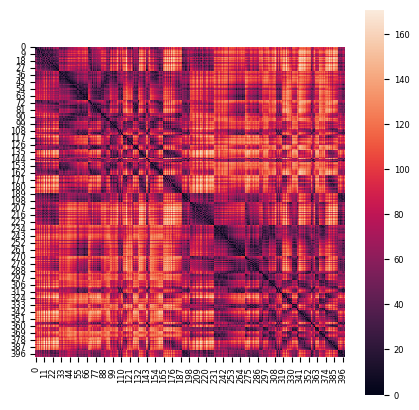

                     R   A   S
ROI Name                      
7Networks_LH_Vis_1 -33 -42 -21
7Networks_LH_Vis_2 -30 -33 -18
7Networks_LH_Vis_3 -36 -62 -17
7Networks_LH_Vis_4 -24 -55  -8
7Networks_LH_Vis_5 -23 -73 -10


In [3]:
# extract cluster centers. These represent dominant patterns of recurrent activity over time
parc_centroids = pd.read_csv(os.path.join(indir, 'Schaefer2018_{0}Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'.format(n_parcels)), index_col=1)
parc_centroids.drop(columns=['ROI Label'], inplace=True)

distance_matrix = distance.pdist(
    parc_centroids, "euclidean"
)  # get euclidean distances between nodes
distance_matrix = distance.squareform(distance_matrix)  # reshape to square matrix

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(distance_matrix, ax=ax, square=True)
plt.show()
print(parc_centroids.head())

In [4]:
file_prefix = '{0}-{1}-Am_optimal-'.format(which_data, atlas)

if which_data == 'HCPYA':
    n_states = 7
elif which_data == 'MICS':
    n_states = 5

c = 1
time_horizon = 1
rho = 1
reference_state = 'xf'
init_weights = 'one'
n_steps = 1000
lr = 0.01
eig_weight = 1.0
reg_weight = 0.0001
reg_type = 'l2'

file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                            n_states, 
                                                                                                                                                            c, time_horizon, rho,
                                                                                                                                                            reference_state, init_weights,
                                                                                                                                                            n_steps, lr, eig_weight, reg_weight, reg_type)
print(file_str)
log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()
# log_args = np.load(os.path.join(outdir, 'multi', file_str + '.npy'), allow_pickle=True).item()

control_energy_static_decay = log_args['control_energy_static_decay']
control_energy_variable_decay = log_args['control_energy_variable_decay']

print(log_args.keys())
print(control_energy_static_decay.shape, control_energy_variable_decay.shape)

HCPYA-Schaefer4007-Am_optimal-optimized-energy_k-7_c-1_T-1_rho-1_refstate-xf_initweights-one_nsteps-1000_lr-0.01_eigweight-1.0_regweight-0.0001_regtype-l2
dict_keys(['state_trajectory', 'control_signals', 'numerical_error', 'control_energy', 'loss', 'eigen_values', 'optimized_weights', 'state_trajectory_variable_decay', 'control_signals_variable_decay', 'numerical_error_variable_decay', 'control_energy_variable_decay', 'state_trajectory_static_decay', 'numerical_error_static_decay', 'control_energy_static_decay', 'control_signals_corr_partial', 'control_energy_partial', 'numerical_error_partial', 'xfcorr_partial', 'control_signals_corr_partial_variable_decay', 'control_energy_partial_variable_decay', 'numerical_error_partial_variable_decay', 'xfcorr_partial_variable_decay'])
(7, 7) (7, 7)


In [5]:
# load rsfMRI clusters
k = n_states
fmri_clusters_file = '{0}_{1}_rsts_fmri_clusters_k-{2}.npy'.format(which_data, atlas, k)
fmri_clusters = np.load(os.path.join(outdir, fmri_clusters_file), allow_pickle=True).item()
print(fmri_clusters.keys())

centroids = fmri_clusters['centroids']
n_states = centroids.shape[0]
n_nodes = centroids.shape[1]
n_transitions = n_states * n_states

print('n_states, {0}; n_nodes, {1}'.format(n_states, n_nodes))

dict_keys(['centroids', 'labels', 'inertia', 'centroid_subj_frac', 'variance_explained'])
n_states, 7; n_nodes, 400


In [6]:
# load adjacency matrix
adjacency = np.load(os.path.join(indir, '{0}_{1}_Am.npy'.format(which_data, atlas)))
strength = adjacency.sum(axis=0)
degree = np.sum(adjacency > 0, axis=0)

# Optimized weights

In [7]:
adjacency_weights = get_adj_weights(log_args, subtract_one=False)

n_states = adjacency_weights.shape[0]
n_transitions = n_states * n_states

adjacency_weights_tmp = adjacency_weights.copy()
mask = np.repeat(np.eye(n_states).astype(bool)[:, :, np.newaxis], n_nodes, axis=2)
adjacency_weights_tmp[mask] = np.nan # mask out self transitions by filling with nans
adjacency_weights_2d = adjacency_weights_tmp.reshape(n_transitions, n_nodes)
self_transition_mask = np.isnan(adjacency_weights_2d)
self_transition_mask = np.all(self_transition_mask, axis=1)
adjacency_weights_2d = adjacency_weights_2d[~self_transition_mask, :]
adjacency_weights_mean = np.mean(adjacency_weights_2d, axis=0)
# adjacency_weights_mean = np.median(adjacency_weights_2d, axis=0)
adjacency_weights_std = np.std(adjacency_weights_2d, axis=0)

print(adjacency_weights.shape, adjacency_weights_2d.shape, adjacency_weights_mean.shape)

np.save(os.path.join(outdir, 'adjacency_weights_mean_{0}_{1}'.format(which_data, atlas)), adjacency_weights_mean)

warning, positive weights found
(7, 7, 400) (42, 400) (400,)


### Averaged over transitions

-1.1923083308822973


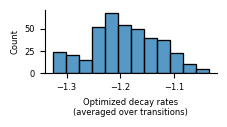

In [8]:
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.25))
sns.histplot(adjacency_weights_mean, ax=ax, kde=False)
x_mean = np.nanmean(adjacency_weights_mean)
print(x_mean)
ax.set_xlabel('Optimized decay rates\n(averaged over transitions)')
sns.despine(ax=ax)
f.tight_layout()
f.savefig(os.path.join(outdir, 'optimized_weights_mean.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)
plt.show()

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


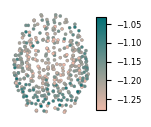

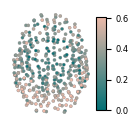

In [9]:
# mean
my_colors = get_my_colors()
colors = [my_colors['conch_shell'],
          my_colors['north_sea_green']]
cm = LinearSegmentedColormap.from_list("Custom", colors, N=n_nodes)

f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights_mean,
                    vmin=np.round(adjacency_weights_mean.min(), 2)+.05, vmax=np.round(adjacency_weights_mean.max(), 2), add_colorbar=True, cmap=cm)
f.savefig(os.path.join(outdir, 'optimized_weights_mean_brain_map_cb.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

# std
colors = [my_colors['north_sea_green'],
          my_colors['conch_shell']]
cm = LinearSegmentedColormap.from_list("Custom", colors, N=n_nodes)

f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights_std,
                    vmin=np.round(adjacency_weights_std.min(), 2), vmax=np.round(adjacency_weights_std.max(), 2)-.15, add_colorbar=True, cmap=cm)
f.savefig(os.path.join(outdir, 'optimized_weights_std_brain_map_cb.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

In [10]:
if which_data == 'MICS':
    adjacency_weights_mean_hcpya = np.load('/home/lindenmp/research_projects/nct_xr/results/HCPYA/adjacency_weights_mean_HCPYA_Schaefer4007.npy')
    
    f, ax = plt.subplots(1, 1, figsize=(2, 2))
    reg_plot(adjacency_weights_mean, adjacency_weights_mean_hcpya, xlabel='Optimized weights (mean)', ylabel='Optimized weights HCP-YA (mean)', ax=ax, annotate='both')

## PCA of Optimized weights

In [11]:
def run_pca(adjacency_weights_2d, n_components=5, verbose=False):
    pca = PCA(n_components=n_components)
    
    pca_results = pca.fit_transform(sp.stats.zscore(adjacency_weights_2d, axis=0))
    if verbose is True:
        print(pca_results.shape)
        print(np.round(pca.explained_variance_ratio_*100))
        print(np.round(pca.explained_variance_ratio_.sum()*100))

    return pca_results, pca

In [12]:
adjacency_weights_2d.shape

(42, 400)

In [13]:
n_components = 5
pca_results, pca = run_pca(adjacency_weights_2d, n_components=n_components, verbose=True)
if which_data == 'HCPYA':
    adjacency_weights_pca = -1 * pca.components_
    results_pca = -1 * pca_results
else:
    adjacency_weights_pca = pca.components_
    results_pca = pca_results

state_loadings_pca = np.zeros((self_transition_mask.shape[0], n_components))
state_loadings_pca[~self_transition_mask, :] = results_pca

print(adjacency_weights_pca.shape, state_loadings_pca.shape, adjacency_weights_pca.max(), adjacency_weights_pca.min())

(42, 5)
[35. 22. 16. 11.  7.]
91.0
(5, 400) (49, 5) 0.14580392498475822 -0.1324355603323687


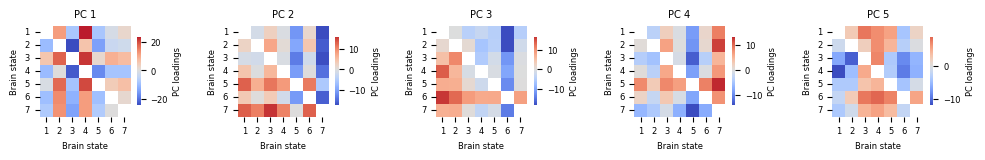

In [14]:
f, ax = plt.subplots(1, n_components, figsize=(2*n_components, 1.5))

for pc in np.arange(n_components):
    plot_data = state_loadings_pca[:, pc].reshape(n_states, n_states)
    mask = np.eye(n_states).astype(bool)
    sns.heatmap(plot_data, mask=mask, square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.75, 'label': 'PC loadings'}, ax=ax[pc])
    ax[pc].set_xlabel('Brain state')
    ax[pc].set_ylabel('Brain state')
    ax[pc].set_title('PC {0}'.format(pc+1))

    x_tick_labels = []
    for tick in ax[pc].get_xticklabels():
        x_tick_labels.append(int(tick.get_text()) + 1)
    ax[pc].set_xticklabels(x_tick_labels, rotation=0)
    y_tick_labels = []
    for tick in ax[pc].get_yticklabels():
        y_tick_labels.append(int(tick.get_text()) + 1)
    ax[pc].set_yticklabels(y_tick_labels, rotation=0)
f.tight_layout()
f.savefig(os.path.join(outdir, "pca_results.svg"), dpi=600, bbox_inches="tight", pad_inches=0.01)

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


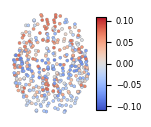

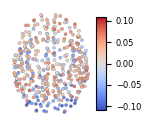

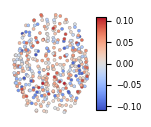

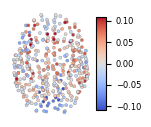

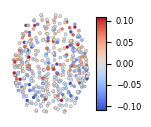

In [15]:
observed_corrs = []
p_vals = []
for i in np.arange(n_components):
    # if i == n_components - 1:
    #     add_colorbar = True
    # else:
    #     add_colorbar = False
    add_colorbar = True
    f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=adjacency_weights_pca[i, :], cmap='coolwarm', vmin=-.11, vmax=.11, add_colorbar=add_colorbar) # vmin=-.11, vmax=.11, 
    f.savefig(os.path.join(outdir, 'adjacency_weights_pc_{0}_brain_map.svg'.format(i)), dpi=600, bbox_inches="tight", pad_inches=0.01)
    
    observed_corr = sp.stats.pearsonr(adjacency_weights_pca[i, :], adjacency_weights_mean)[0]
    p_val = sp.stats.pearsonr(adjacency_weights_pca[i, :], adjacency_weights_mean)[1]

    observed_corrs.append(observed_corr)
    p_vals.append(p_val)

In [16]:
p_vals_fdr = get_fdr_p(np.asarray(p_vals))

for i in np.arange(n_components):
    print('corr(PC {0}, mean weights). r = {1}; p = {2}'.format(i+1, np.round(observed_corrs[i], 2), np.round(p_vals[i], 3)))
    # print('corr(PC {0}, mean weights). r = {1}; pFDR = {2}'.format(i+1, np.round(observed_corrs[i], 2), np.round(p_vals_fdr[i], 3)))

corr(PC 1, mean weights). r = 0.13; p = 0.01
corr(PC 2, mean weights). r = 0.07; p = 0.188
corr(PC 3, mean weights). r = 0.13; p = 0.011
corr(PC 4, mean weights). r = -0.13; p = 0.01
corr(PC 5, mean weights). r = -0.11; p = 0.03


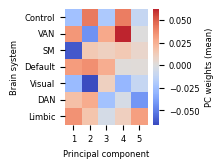

In [17]:
yeo_systems = ['Cont', 'SalVentAttn', 'SomMot', 'Default', 'Vis', 'DorsAttn', 'Limbic'] # k = 7
yeo_systems_labels = ['Control', 'VAN', 'SM', 'Default', 'Visual', 'DAN', 'Limbic'] # k = 7
n_systems = len(yeo_systems)
mean_activity = np.zeros((n_systems, n_components))
for system_idx in np.arange(n_systems):
    system_mask = get_schaefer_system_mask(parc_centroids.index, system=yeo_systems[system_idx])
    for pc_idx in np.arange(n_components):
        mean_activity[system_idx, pc_idx] = adjacency_weights_pca[pc_idx, system_mask].mean()
        
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

sns.heatmap(mean_activity, square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 1, 'label': 'PC weights (mean)'}) # vmin=-5, vmax=5, 
ax.set_xlabel('Principal component')
ax.set_ylabel('Brain system')

x_tick_labels = []
for tick in ax.get_xticklabels():
    x_tick_labels.append(int(tick.get_text()) + 1)
ax.set_xticklabels(x_tick_labels, rotation=0)
ax.set_yticklabels(yeo_systems_labels, rotation=0)
f.savefig(os.path.join(outdir, "weights_pca_system_mapping.svg".format(n_states, pc_idx)), dpi=600, bbox_inches="tight", pad_inches=0.01)

# Load brain maps

In [18]:
# myelin matrix
if which_data == 'HCPYA':
    myelin = np.load(os.path.join(indir, '{0}_{1}_myelin.npy'.format(which_data, atlas)))
    myelin = myelin.mean(axis=1)
    TR=0.720
elif which_data == 'MICS':
    myelin = np.loadtxt('/mnt/storage_ssd_raid/research_data/MICA-MICs/MICs/derivatives/gradients/gradients/ses-01/group/anat/micro_profiles/group_ses-01_space-fsnative_atlas-schaefer400_desc-mpcGradient.txt',
                        dtype=np.float64, delimiter=',')
    myelin = myelin[:, 0]
    inf_mask = np.isinf(myelin)
    myelin = myelin[~inf_mask]

rsts = np.load(os.path.join(indir, '{0}_{1}_rsts.npy'.format(which_data, atlas)))
n_parcels = rsts.shape[1]
n_scans = rsts.shape[2]
n_subs = rsts.shape[-1]
timescales = np.zeros((n_parcels, n_scans, n_subs))
for i in tqdm(np.arange(n_subs)):
    for j in np.arange(n_scans):
        for k in np.arange(n_parcels):
            try:
                _, timescales[k, j, i] = compute_acf(rsts[:, k, j, i])
            except:
                timescales[k, j, i] = np.nan
timescales = timescales[:, 0, :]
timescales = np.nanmean(timescales, axis=1)

if which_data == 'MICS':
    timescales_mask = np.abs(sp.stats.zscore(timescales)) < 2
else:
    timescales_mask = np.zeros(n_nodes).astype(bool)
    timescales_mask[:] = True

print(timescales.shape)

100%|██████████| 960/960 [00:29<00:00, 32.84it/s]

(400,)


In [19]:
observed_corrs = []
p_vals = []
for i in np.arange(2):
    observed_corr = sp.stats.spearmanr(adjacency_weights_pca[i], degree)[0]
    p_val = sp.stats.spearmanr(adjacency_weights_pca[i], degree)[1]

    observed_corrs.append(observed_corr)
    p_vals.append(p_val)
    
p_vals_fdr = get_fdr_p(np.asarray(p_vals))

for i in np.arange(2):
    print('corr(PC, degree). rho = {:.2f}; pFDR = {:.2f}'.format(observed_corrs[i], p_vals_fdr[i]))
    
observed_corrs = []
p_vals = []
for i in np.arange(2):
    observed_corr = sp.stats.spearmanr(adjacency_weights_pca[i], strength)[0]
    p_val = sp.stats.spearmanr(adjacency_weights_pca[i], strength)[1]

    observed_corrs.append(observed_corr)
    p_vals.append(p_val)
    
p_vals_fdr = get_fdr_p(np.asarray(p_vals))

for i in np.arange(2):
    print('corr(PC, strength). rho = {:.2f}; pFDR = {:.2f}'.format(observed_corrs[i], p_vals_fdr[i]))

corr(PC, degree). rho = 0.10; pFDR = 0.08
corr(PC, degree). rho = 0.07; pFDR = 0.17
corr(PC, strength). rho = 0.11; pFDR = 0.06
corr(PC, strength). rho = 0.04; pFDR = 0.40


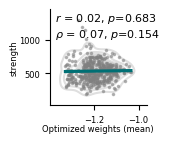

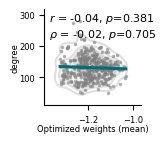

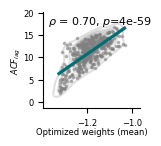

In [20]:
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
reg_plot(adjacency_weights_mean, strength, xlabel='Optimized weights (mean)', ylabel='strength', ax=ax, annotate='both')
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
reg_plot(adjacency_weights_mean, degree, xlabel='Optimized weights (mean)', ylabel='degree', ax=ax, annotate='both')
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
reg_plot(adjacency_weights_mean, timescales, xlabel='Optimized weights (mean)', ylabel='$ACF_{lag}$', ax=ax, annotate='spearman')
f.savefig(os.path.join(outdir, 'average_optimized_weights_timescales_correlation.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


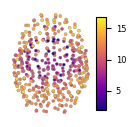

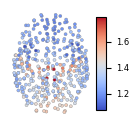

In [21]:
f = brain_scatter_plot(parcel_coords=parc_centroids[timescales_mask], node_data=timescales[timescales_mask], cmap='plasma', add_colorbar=True)
f.savefig(os.path.join(outdir, 'empirical_timescales_brain_map.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

f = brain_scatter_plot(parcel_coords=parc_centroids, node_data=myelin, cmap='coolwarm', add_colorbar=True)
f.savefig(os.path.join(outdir, 'myelin_brain_map.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)

In [22]:
n_perms = 5000
base = Base(x=timescales, D=distance_matrix)
timescales_surrogates = base(n=n_perms)

In [23]:
observed_corrs = []
p_vals = []
for i in np.arange(n_components):
    observed_corr = sp.stats.spearmanr(adjacency_weights_pca[i, timescales_mask], timescales[timescales_mask])[0]
    p_val = sp.stats.spearmanr(adjacency_weights_pca[i, timescales_mask], timescales[timescales_mask])[1]

    observed_corrs.append(observed_corr)
    p_vals.append(p_val)
    
p_vals_fdr = get_fdr_p(np.asarray(p_vals))

for i in np.arange(n_components):
    print('corr(PC, timescale). rho = {:.2f}; pFDR = {:.2f}'.format(observed_corrs[i], p_vals_fdr[i]))

corr(PC, timescale). rho = 0.42; pFDR = 0.00
corr(PC, timescale). rho = 0.22; pFDR = 0.00
corr(PC, timescale). rho = -0.00; pFDR = 0.94
corr(PC, timescale). rho = -0.09; pFDR = 0.14
corr(PC, timescale). rho = -0.01; pFDR = 0.94


100%|██████████| 5000/5000 [00:00<00:00, 6718.10it/s]


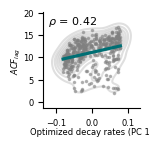

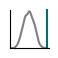

0.42 $\mathit{p}$=0e+00


100%|██████████| 5000/5000 [00:00<00:00, 6715.92it/s]


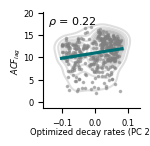

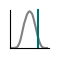

0.22 $\mathit{p}$=0.054


In [24]:
for i in np.arange(2):
    # f, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))
    f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
    # xlabel = '(fast   -->   slow)\nOptimized weights\n(PC coefs.)'
    ylabel = '$ACF_{lag}$'
    xlabel = 'Optimized decay rates (PC {0})'.format(i+1)
    reg_plot(adjacency_weights_pca[i, timescales_mask], timescales[timescales_mask], xlabel=xlabel, ylabel=ylabel, ax=ax, annotate='spearman', add_pval=False)

    # ax.set_title('PC {0}'.format(i + 1))
    f.savefig(os.path.join(outdir, 'optimized_weights_PC_{0}_timescales_correlation.svg'.format(i)), dpi=600, bbox_inches="tight", pad_inches=0.01)

    f, ax = plt.subplots(1, figsize=(.5, .5))
    observed_corr = sp.stats.spearmanr(adjacency_weights_pca[i, timescales_mask], timescales[timescales_mask])[0]
    null_corr = np.zeros(n_perms)
    for j in tqdm(np.arange(n_perms)):
        null_corr[j] = sp.stats.spearmanr(adjacency_weights_pca[i, timescales_mask], timescales_surrogates[j, timescales_mask])[0]
    p_val = get_null_p(observed_corr, null_corr, version='smallest')
    null_plot(observed_corr, null_corr, '', ax=ax, p_val=p_val, add_text=False, use_kde=True)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    f.savefig(os.path.join(outdir, 'optimized_weights_PC_{0}_timescales_correlation_null.svg'.format(i)), dpi=600, bbox_inches="tight", pad_inches=0.01)
    plt.show()
    print(np.round(observed_corr, 2), get_p_val_string(p_val))
    # print(np.round(observed_corr, 2), p_val)

# Gene expression analysis

In [25]:
from sklearn.impute import SimpleImputer

# Load Allen Human Brain Atlas (AHBA) gene expression
gene_expression = pd.read_csv('/mnt/synology/work/research_data/abagen/expression_schaefer400-7.csv', index_col=0)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
gene_expression = pd.DataFrame(data=imputer.fit_transform(gene_expression.values), columns=gene_expression.columns, index=gene_expression.index)

n_gene_maps = gene_expression.shape[1]
print(gene_expression.head())

# Cell Types
Jorstad_schaefer400 = pd.read_csv(os.path.join(indir, 'cell_maps_Zhang2024', 'schaeffer_Jorstad_FullCombinedFullCombined_400_7Net_expr_mat_new_NormZscore0.3.csv'), header=0, index_col=-1)
Jorstad_schaefer400 = Jorstad_schaefer400.transpose()
# Jorstad_schaefer400.replace(0, 0.0001, inplace=True)
print(Jorstad_schaefer400.head())

           A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT      AAAS  \
label                                                                         
1      0.607480  0.665241  0.336723  0.512871  0.535616  0.349362  0.385011   
2      0.693737  0.537774  0.475546  0.463217  0.451536  0.431581  0.326428   
3      0.446310  0.490555  0.446556  0.454476  0.478724  0.285521  0.542609   
4      0.421246  0.391275  0.424500  0.610471  0.561524  0.509270  0.501330   
5      0.435436  0.188208  0.503914  0.537667  0.720855  0.575021  0.642950   

           AACS   AADACL3     AADAT  ...      ZW10    ZWILCH     ZWINT  \
label                                ...                                 
1      0.604183  0.714513  0.612679  ...  0.434829  0.686842  0.642691   
2      0.675244  0.470909  0.481477  ...  0.397754  0.693257  0.701007   
3      0.566711  0.512363  0.633447  ...  0.452174  0.529415  0.456184   
4      0.610072  0.631187  0.461455  ...  0.540839  0.429449  0.511955   
5 

### Permute PCs

In [26]:
n_perms = 5000
n_components = 1
pc_surrogates = np.zeros((n_components, n_perms, n_nodes))
for pc in tqdm(np.arange(n_components)):
    base = Base(x=adjacency_weights_pca[pc, :], D=distance_matrix)
    surrogates = base(n=n_perms)
    pc_surrogates[pc] = surrogates

100%|██████████| 1/1 [04:13<00:00, 253.36s/it]


### Create data frame for gene maps

In [27]:
df_neuro = pd.DataFrame(index=np.arange(n_nodes))

df_neuro['Myelin'] = myelin
df_neuro['AHBA-SST'] = gene_expression['SST'].values
df_neuro['AHBA-PVALB'] = gene_expression['PVALB'].values
df_neuro['PVALB-Basket'] = Jorstad_schaefer400['Pvalb'].values
# df_neuro['PVALB-Chandelier'] = Jorstad_schaefer400['Chandelier'].values
df_neuro['PVALB-Chandelier'] = np.log(Jorstad_schaefer400['Chandelier'].values)
df_neuro.loc[np.isinf(df_neuro['PVALB-Chandelier']), 'PVALB-Chandelier'] = np.nan
# df_neuro['Jorstad-SST'] = Jorstad_schaefer400['Sst'].values

# VIP and excitatory genes from Deco 2021 (response to R3)
df_neuro['AHBA-VIP'] = gene_expression['VIP'].values
ampa = ['GRIA1', 'GRIA2', 'GRIA3', 'GRIA4']
nmda = ['GRIN1', 'GRIN2A', 'GRIN2B', 'GRIN2C']
df_neuro['AHBA-AMPA'] = gene_expression.loc[:, ampa].mean(axis=1).values
df_neuro['AHBA-NMDA'] = gene_expression.loc[:, nmda].mean(axis=1).values

/tmp/ipykernel_228173/2490208640.py:8: RuntimeWarning: divide by zero encountered in log
  df_neuro['PVALB-Chandelier'] = np.log(Jorstad_schaefer400['Chandelier'].values)


In [28]:
# n_perms = 5000
# base = Base(x=adjacency_weights_mean, D=distance_matrix)
# mean_surrogates = base(n=n_perms)

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


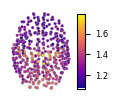

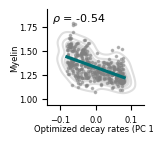

100%|██████████| 5000/5000 [00:00<00:00, 5582.99it/s]


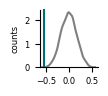

-0.54 $\mathit{p}$=0e+00


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


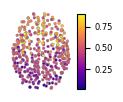

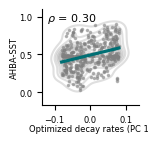

100%|██████████| 5000/5000 [00:00<00:00, 6498.86it/s]


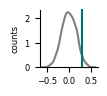

0.3 $\mathit{p}$=3e-02


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


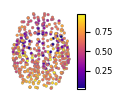

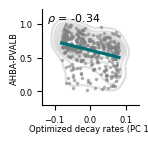

100%|██████████| 5000/5000 [00:00<00:00, 6718.84it/s]


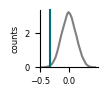

/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


-0.34 $\mathit{p}$=2e-03


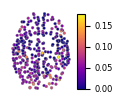

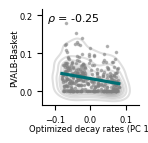

100%|██████████| 5000/5000 [00:00<00:00, 6569.72it/s]


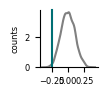

-0.25 $\mathit{p}$=7e-03


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


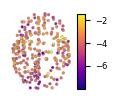

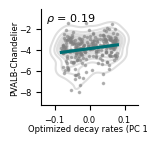

100%|██████████| 5000/5000 [00:00<00:00, 7188.58it/s]


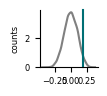

0.19 $\mathit{p}$=3e-02


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


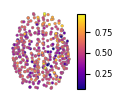

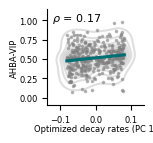

100%|██████████| 5000/5000 [00:00<00:00, 6557.61it/s]


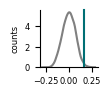

0.17 $\mathit{p}$=8e-03


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


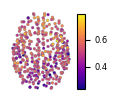

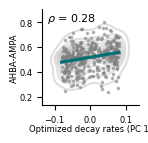

100%|██████████| 5000/5000 [00:00<00:00, 6620.67it/s]


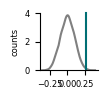

0.28 $\mathit{p}$=3e-03


/home/lindenmp/research_projects/snaplab_tools/snaplab_tools/plotting/plotting.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


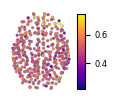

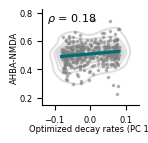

100%|██████████| 5000/5000 [00:00<00:00, 6742.12it/s]


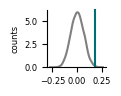

0.18 $\mathit{p}$=3e-03


In [29]:
my_colors = get_my_colors(cat_trio=True, as_list=True)
pc = 0
adjacency_weights_plot = adjacency_weights_pca[pc, :]
# adjacency_weights_plot = adjacency_weights_mean

for column in df_neuro.columns:
    brain_map = df_neuro[column].values
    nan_mask = ~np.isnan(brain_map)

    f = brain_scatter_plot(parcel_coords=parc_centroids[nan_mask], node_data=brain_map[nan_mask], fig_height=1, add_colorbar=True)
    plt.show()
    f.savefig(os.path.join(outdir, '{0}_brain_map.svg'.format(column)), dpi=600, bbox_inches="tight", pad_inches=0.01)

    f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
    xlabel = 'Optimized decay rates (PC {0})'.format(pc+1)
    reg_plot(adjacency_weights_plot[nan_mask], brain_map[nan_mask], xlabel=xlabel, ylabel=column, ax=ax, annotate='spearman', add_pval=False)
    plt.show()
    f.savefig(os.path.join(outdir, 'optimized_weights_{0}_correlation.svg'.format(column)), dpi=600, bbox_inches="tight", pad_inches=0.01)

    f, ax = plt.subplots(1, figsize=(0.75, 0.75))
    observed_corr = sp.stats.spearmanr(adjacency_weights_plot[nan_mask], brain_map[nan_mask])[0]
    null_corr = np.zeros(n_perms)
    for i in tqdm(np.arange(n_perms)):
        null_corr[i] = sp.stats.spearmanr(pc_surrogates[pc, i, nan_mask], brain_map[nan_mask])[0]
        # null_corr[i] = sp.stats.spearmanr(mean_surrogates[i, nan_mask], brain_map[nan_mask])[0]

    p_val = get_null_p(observed_corr, null_corr, version='smallest')
    null_plot(observed_corr, null_corr, '', ax=ax, p_val=p_val, add_text=False, use_kde=True)
    # f.tight_layout()
    plt.show()
    f.savefig(os.path.join(outdir, 'optimized_weights_{0}_correlation_null.svg'.format(column)), dpi=600, bbox_inches="tight", pad_inches=0.01)
    print(np.round(observed_corr, 2), get_p_val_string(p_val))

# Supplementary figures

In [30]:
# load greedy energy thing from Jason
if which_data == 'HCPYA':
    data = sp.io.loadmat(os.path.join(outdir, 'data_removed_greedy.mat'))
    print(data.keys())
    energy_current = data['Ecurr']
    index_removed = data['Irem']
    print(energy_current.shape, index_removed.shape)

    data = sp.io.loadmat(os.path.join(outdir, 'data_removed_greedy_uni.mat'))
    print(data.keys())
    energy_current_standard = data['Ecurr']
    index_removed_standard = data['Irem']
    print(energy_current_standard.shape, index_removed_standard.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Ecurr', 'Irem'])
(7, 7, 350) (7, 7, 400)
dict_keys(['__header__', '__version__', '__globals__', 'Ecurr', 'Irem'])
(7, 7, 350) (7, 7, 400)


(42, 400)
0


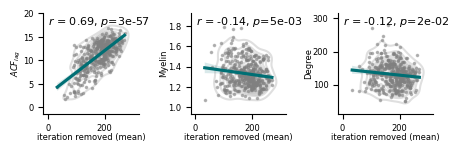

In [31]:
if which_data == 'HCPYA':
    # state_i = 0
    # state_j = 6
    # index_removed_plot = index_removed[state_i, state_j]
    # nan_mask = np.isnan(index_removed_plot)

    mask = np.eye(n_states) == 0
    print(index_removed[mask].shape)
    index_removed_plot = np.nanmean(index_removed[mask], axis=0)
    # index_removed_plot = np.nanmean(index_removed_standard[mask], axis=0)
    nan_mask = np.isnan(index_removed_plot)

    print(np.sum(nan_mask))

    f, ax = plt.subplots(1, 3, figsize=(4.5, 1.5))
    reg_plot(index_removed_plot[~nan_mask], timescales[~nan_mask], xlabel='iteration removed (mean)', ylabel='$ACF_{lag}$', ax=ax[0], annotate='pearson')
    reg_plot(index_removed_plot[~nan_mask], myelin[~nan_mask], xlabel='iteration removed (mean)', ylabel='Myelin', ax=ax[1], annotate='pearson')
    reg_plot(index_removed_plot[~nan_mask], degree[~nan_mask], xlabel='iteration removed (mean)', ylabel='Degree', ax=ax[2], annotate='pearson')
    f.tight_layout()
    plt.show()
    f.savefig(os.path.join(outdir, "greedy_search_average_corrs.svg"), dpi=600, bbox_inches="tight", pad_inches=0.01)

In [32]:
run_cell = True

In [33]:
if run_cell:
    df_neuro = pd.DataFrame(index=np.arange(n_nodes))

    df_neuro['$ACF_{lag}$'] = timescales
    df_neuro['SST expression (AHBA)'] = gene_expression['SST'].values
    df_neuro['PVALB expression (AHBA)'] = gene_expression['PVALB'].values
    df_neuro['PVALB-Basket (Zhang et al. 2024)'] = Jorstad_schaefer400['Pvalb'].values
    df_neuro['PVALB-Chandelier (Zhang et al. 2024)'] = np.log(Jorstad_schaefer400['Chandelier'].values)

/tmp/ipykernel_228173/755164063.py:8: RuntimeWarning: divide by zero encountered in log
  df_neuro['PVALB-Chandelier (Zhang et al. 2024)'] = np.log(Jorstad_schaefer400['Chandelier'].values)


[ 2  3  4  5  6  7  8  9 10 11 12 13]
2
3
4
5
6
7
8
9
10
11
12
13


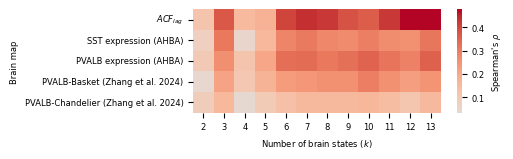

In [34]:
if run_cell:
    k_range = np.arange(2, 14)
    print(k_range)

    df_corr_arange = pd.DataFrame(index=k_range, columns=df_neuro.columns)

    for n_states in k_range:
        print(n_states)
        file_str = '{0}optimized-energy_k-{1}_c-{2}_T-{3}_rho-{4}_refstate-{5}_initweights-{6}_nsteps-{7}_lr-{8}_eigweight-{9}_regweight-{10}_regtype-{11}'.format(file_prefix, 
                                                                                                                                                                    n_states, 
                                                                                                                                                                    c, time_horizon, rho,
                                                                                                                                                                    reference_state, init_weights,
                                                                                                                                                                    n_steps, lr, eig_weight, reg_weight, reg_type)
        # print(file_str)
        log_args = np.load(os.path.join(outdir, file_str + '.npy'), allow_pickle=True).item()
        # log_args.keys()

        adjacency_weights = get_adj_weights(log_args, subtract_one=True)
        adjacency_weights_2d = adjacency_weights.reshape(log_args['control_energy'].shape[0] * log_args['control_energy'].shape[0], n_nodes)
        pca_results, pca = run_pca(adjacency_weights_2d, n_components=2)
        adjacency_weights_pca_repl = pca.components_[0]
        adjacency_weights_pca_repl = -1 * adjacency_weights_pca_repl

        for column in df_neuro.columns:
            brain_map = df_neuro[column].values
            nan_mask = ~np.isnan(brain_map)

            df_corr_arange.loc[n_states, column] = sp.stats.spearmanr(adjacency_weights_pca_repl[nan_mask], brain_map[nan_mask])[0]
            
    f, ax = plt.subplots(1, 1, figsize=(4, 1.5))
    sns.heatmap(df_corr_arange.abs().astype(float).T, square=True, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.9, 'label': 'Spearman\'s $\\rho$'}) # vmin=-5, vmax=5, 
    ax.set_xlabel('Number of brain states ($k$)')
    ax.set_ylabel('Brain map')
    f.savefig(os.path.join(outdir, 'optimized_weights_corr_brain_maps_krange.svg'), dpi=600, bbox_inches="tight", pad_inches=0.01)